In [960]:
%load_ext lab_black

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.corpus import stopwords
from textblob import Word
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from livelossplot import PlotLossesKeras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer

In [688]:
!jupyter nbconvert --to script Untitled.ipynb

[NbConvertApp] Converting notebook Untitled.ipynb to script
[NbConvertApp] Writing 7348 bytes to Untitled.py


In [686]:
df = pd.read_excel('Participants_Data/Data_Train.xlsx')
df_test = pd.read_excel('Participants_Data/Data_Test.xlsx')

In [578]:
len(df)

6237

In [579]:
df.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [580]:
df['RatingValue'] = df['Reviews'].apply(lambda x: float(x.split()[0])/5)

In [581]:
df['NumReview'] = df['Ratings'].apply(lambda x: int(x.split()[0].replace(',', '')))

In [582]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthsMaxDays = {
    'Jan': 31, 
    'Feb': 28, 
    'Mar': 31, 
    'Apr': 30, 
    'May': 31, 
    'Jun': 30, 
    'Jul': 31, 
    'Aug': 31, 
    'Sep': 30, 
    'Oct': 31, 
    'Nov': 30, 
    'Dec': 31
}
months_to_num = {}
for i, m in enumerate(months):
    months_to_num[m] = i+1
months_to_num

{'Jan': 1,
 'Feb': 2,
 'Mar': 3,
 'Apr': 4,
 'May': 5,
 'Jun': 6,
 'Jul': 7,
 'Aug': 8,
 'Sep': 9,
 'Oct': 10,
 'Nov': 11,
 'Dec': 12}

In [583]:
df.Edition = df.Edition.apply(lambda x: x.replace('–', '-').replace('-', '-'))
df.loc[df.Edition.str.match('.*\(\w+\).*'), 'Edition'] = df.loc[df.Edition.str.match('.*\(\w+\).*'), 'Edition'].apply(lambda x: re.sub('\(\w+\),', '', x))
df.loc[df.Edition.str.match(r'.*[^\d]+$'), 'EditionDate'] = np.nan # pattern 1, year and month 

In [584]:
len(df)

6237

In [585]:
df.loc[df.Edition.str.match(r'.*\d+$'), 'EditionDate'] = df.Edition.apply(lambda x: x.split(',')[-1].split('-')[-1].strip())

In [586]:
df.EditionDate

0       10 Mar 2016
1        7 Nov 2012
2       25 Feb 1982
3        5 Oct 2017
4       10 Oct 2006
           ...     
6232     8 Aug 2018
6233    21 Nov 2016
6234     8 Jun 2006
6235    15 Jan 2015
6236    21 Dec 2016
Name: EditionDate, Length: 6237, dtype: object

In [587]:
df['Year'] = df.EditionDate.apply(lambda x: int(x[-4:].strip()) if pd.notnull(x) else np.nan)
df['Year'].unique()

array([2016., 2012., 1982., 2017., 2006., 2009., 2018., 2015., 2013.,
       1999., 2002., 2011., 1991., 2014., 1989., 2000., 2005., 2019.,
       2008., 2004., 2010., 2007., 2001., 1969., 1993., 1992., 2003.,
       1996.,   nan, 1997., 1995., 1987., 1986., 1990., 1988., 1981.,
       1976., 1994., 1998., 1977., 1974., 1983., 1971., 1985., 1978.,
       1964., 1984., 1980., 1979., 1960., 1970., 1975., 1905., 1900.,
       1961., 1925., 1973.])

In [588]:
df['Month'] = df.EditionDate.apply(lambda x: x[-8:-4] if (pd.notnull(x) and len(x)>8) else np.nan)

In [589]:
df['Day'] = df.EditionDate.apply(lambda x: int(x[-11:-9].strip()) if (pd.notnull(x) and len(x)>=10) else np.nan)

<AxesSubplot:xlabel='count', ylabel='BookCategory'>

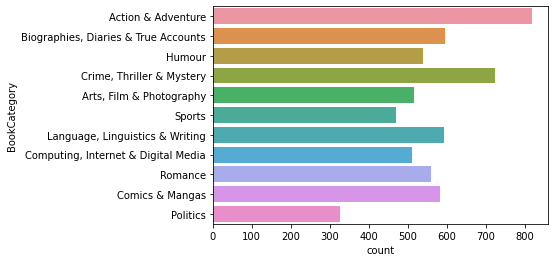

In [590]:
sns.countplot(data=df, y='BookCategory')

In [591]:
df['PrintEdition'] = df.Edition.apply(lambda x: x.split(',')[0])

<AxesSubplot:xlabel='count', ylabel='PrintEdition'>

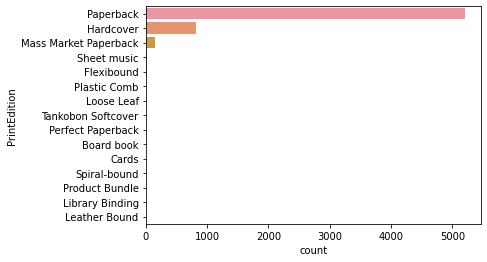

In [592]:
sns.countplot(data=df, y='PrintEdition')

In [593]:
df.to_csv('processed_edition.csv') # write to file to save time later

In [594]:
# df.loc[df.Edition.str.contains('Import'), 'IsImported'] = 1 # mark books that were imported
df['IsImported'] = df.Edition.str.contains('Import')

In [595]:
df['IsBook'] = df.Genre.str.contains('(Books)')

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [596]:
df['IsMultipleAuthor'] = df.Author.str.match('.*[,&-].*')


<AxesSubplot:xlabel='count', ylabel='IsMultipleAuthor'>

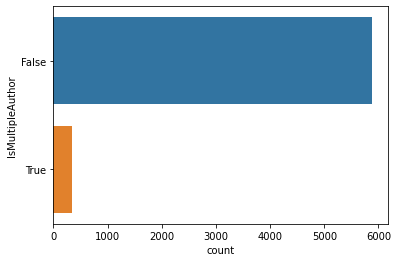

In [597]:
sns.countplot(data=df, y='IsMultipleAuthor')

In [598]:
df['IsSpecialAuthor'] = df.Author.apply(lambda x: any(i for i in x.lower().split() if i in ['phd.', 'phd', 'dr', 'dr.', 'prof', 'prof.', 'sir', 'sir.', 'm.d.', 'm.d.', 'mr', 'mr.', 'mrs', 'mrs.', 'm.a', 'm.a.']))


<AxesSubplot:xlabel='count', ylabel='IsSpecialAuthor'>

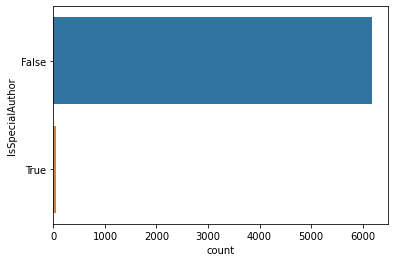

In [599]:
sns.countplot(data=df, y='IsSpecialAuthor')

<AxesSubplot:xlabel='count', ylabel='IsBook'>

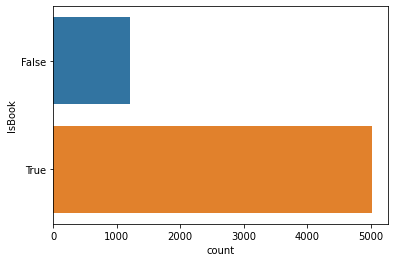

In [600]:
sns.countplot(data=df, y='IsBook')

In [601]:
# prepare to generate word embbeding vectors
glove_input_file = '/Users/kdang/Documents/glove.6B/glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  after removing the cwd from sys.path.


(400000, 100)

In [602]:
model = KeyedVectors.load_word2vec_format(word2vec_output_file)

In [603]:
def processTextColumn(df, col):
    df[f'{col}Token'] = df[col].str.lower()
    df[f'{col}Token'] = df[f'{col}Token'].str.replace('[^\w\s]', '').apply(lambda x: [Word(i).lemmatize() for i in x.split()])
    stop = stopwords.words('english')
    df[f'{col}Token'] = df[f'{col}Token'].apply(lambda x: [i for i in x if i not in stop])
    df[f'{col}Vector'] = df[f'{col}Token'].apply(lambda x: np.mean([(model[i] if i in model else np.zeros(100)) for i in x], axis=0) if x else  np.zeros(100))

In [604]:
processTextColumn(df, 'Synopsis')
processTextColumn(df, 'BookCategory')
processTextColumn(df, 'Title')
processTextColumn(df, 'Genre')
df = df.drop(columns=['BookCategoryToken', 'BookCategoryToken', 'TitleToken', 'GenreToken'])

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [605]:
min_year = df.Year.min()
min_year
max_year = df.Year.max()
max_year
random.randrange(min_year, max_year+1)
df.loc[pd.isnull(df.Year), 'Year'] = df.loc[pd.isnull(df.Year), 'Year'].apply(lambda x: random.randrange(min_year, max_year+1))

In [606]:
df.Month.unique()

array(['Mar ', 'Nov ', 'Feb ', 'Oct ', 'May ', 'Dec ', 'Jan ', 'Jun ',
       'Jul ', 'Sep ', nan, 'Aug ', 'Apr '], dtype=object)

In [607]:
df.loc[pd.isnull(df.Month), 'Month'] = df.loc[pd.isnull(df.Month), 'Month'].apply(lambda x: random.choice(months))

In [608]:
df.loc[pd.isnull(df.Day), 'Day'] = df.loc[df.loc[pd.isnull(df.Day)].index, 'Month'].apply(lambda x: random.randint(1, monthsMaxDays[x]+1))

<AxesSubplot:xlabel='count', ylabel='IsSpecialAuthor'>

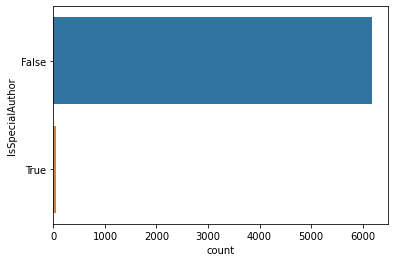

In [609]:
sns.countplot(data=df, y='IsSpecialAuthor')

<AxesSubplot:>

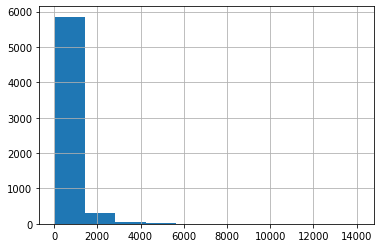

In [610]:
df.Price.hist(bins=10)

In [795]:
df.Price.max()

14100.0

In [611]:
bins = [0, 1000, 5000, 100000]
df['PriceBinned'] = np.searchsorted(bins, df['Price'].values)

In [612]:
df.groupby('PriceBinned').count()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price,RatingValue,...,PrintEdition,IsImported,IsBook,IsMultipleAuthor,IsSpecialAuthor,SynopsisToken,SynopsisVector,BookCategoryVector,TitleVector,GenreVector
PriceBinned,,,,,,,,,,,,,,,,,,,,,
1,5520,5520,5520,5520,5520,5520,5520,5520,5520,5520,...,5520,5520,5520,5520,5520,5520,5520,5520,5520,5520
2,696,696,696,696,696,696,696,696,696,696,...,696,696,696,696,696,696,696,696,696,696
3,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21


In [613]:
df['IsImported'] = df['IsImported'].astype(int)
df['Year'] = df['Year'].astype(int)
df['IsBook'] = df['IsBook'].astype(int)
df['IsMultipleAuthor'] = df['IsMultipleAuthor'].astype(int)
df['IsSpecialAuthor'] = df['IsSpecialAuthor'].astype(int)

In [627]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               6237 non-null   object 
 1   Author              6237 non-null   object 
 2   Edition             6237 non-null   object 
 3   Reviews             6237 non-null   object 
 4   Ratings             6237 non-null   object 
 5   Synopsis            6237 non-null   object 
 6   Genre               6237 non-null   object 
 7   BookCategory        6237 non-null   object 
 8   Price               6237 non-null   float64
 9   RatingValue         6237 non-null   float64
 10  NumReview           6237 non-null   int64  
 11  EditionDate         6216 non-null   object 
 12  Year                6237 non-null   int64  
 13  Month               6237 non-null   object 
 14  Day                 6237 non-null   float64
 15  PrintEdition        6237 non-null   object 
 16  IsImpo

In [668]:
df_processed = df.copy()
df_processed = df_processed.drop(columns='Title Author Edition Reviews Ratings Synopsis Genre BookCategory EditionDate SynopsisToken'.split())

In [669]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               6237 non-null   float64
 1   RatingValue         6237 non-null   float64
 2   NumReview           6237 non-null   int64  
 3   Year                6237 non-null   int64  
 4   Month               6237 non-null   object 
 5   Day                 6237 non-null   float64
 6   PrintEdition        6237 non-null   object 
 7   IsImported          6237 non-null   int64  
 8   IsBook              6237 non-null   int64  
 9   IsMultipleAuthor    6237 non-null   int64  
 10  IsSpecialAuthor     6237 non-null   int64  
 11  SynopsisVector      6237 non-null   object 
 12  BookCategoryVector  6237 non-null   object 
 13  TitleVector         6237 non-null   object 
 14  GenreVector         6237 non-null   object 
 15  PriceBinned         6237 non-null   int64  
dtypes: flo

In [670]:
df_processed['Year'] = MinMaxScaler().fit_transform([[i] for i in df.Year])
df_processed['NumReview'] = MinMaxScaler().fit_transform([[i] for i in df.NumReview])

In [671]:
def categorical_to_column(df, col):
    for i in df[col].unique():
        col_name = f'{col}_{i}'
        df.loc[df[col]==i, col_name] = 1
        df[col_name] = df[col_name].fillna(0)        
        df[col_name] = df[col_name].astype(int)

In [672]:
categorical_to_column(df_processed, 'Month')
categorical_to_column(df_processed, 'Day')
categorical_to_column(df_processed, 'PrintEdition')
df_processed = df_processed.drop(columns=['Month', 'Day', 'PrintEdition'])

In [673]:
for col in ['GenreVector', 'TitleVector', 'BookCategoryVector', 'SynopsisVector']:
    for i in range(100):
        df_processed[f'{col}{i}'] = df_processed[col].apply(lambda x: x[i])
df_processed = df_processed.drop(columns=['GenreVector', 'TitleVector', 'BookCategoryVector', 'SynopsisVector'])

In [674]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Columns: 480 entries, Price to SynopsisVector99
dtypes: float64(404), int64(76)
memory usage: 22.8 MB


In [675]:
xtrain, xtest, ytrain, ytest = train_test_split(df_processed.drop(columns=['Price']), df_processed.Price, stratify=df['PriceBinned'])
xtrain = xtrain.drop(columns=['PriceBinned'])
xtest = xtest.drop(columns=['PriceBinned'])

In [745]:
mlp = MLPRegressor(verbose=True, validation_fraction=0.1, max_iter=10000, tol=.1, hidden_layer_sizes=(100, 50), early_stopping=True, n_iter_no_change=200 )
mlp.fit(xtrain, ytrain)

Iteration 1, loss = 325491.48110319
Validation score: -0.296469
Iteration 2, loss = 283590.02376593
Validation score: -0.170144
Iteration 3, loss = 281591.70616842
Validation score: -0.166014
Iteration 4, loss = 279284.43986033
Validation score: -0.153270
Iteration 5, loss = 274471.58656041
Validation score: -0.155400
Iteration 6, loss = 268433.88147197
Validation score: -0.082936
Iteration 7, loss = 259458.68991622
Validation score: -0.093208
Iteration 8, loss = 255892.14479384
Validation score: -0.012965
Iteration 9, loss = 247955.27302932
Validation score: -0.015258
Iteration 10, loss = 241519.42522603
Validation score: -0.029421
Iteration 11, loss = 236468.07196805
Validation score: -0.190379
Iteration 12, loss = 247929.96645549
Validation score: 0.042009
Iteration 13, loss = 232437.56648440
Validation score: -0.071673
Iteration 14, loss = 233645.77774631
Validation score: 0.070384
Iteration 15, loss = 226338.05141838
Validation score: 0.068718
Iteration 16, loss = 224791.46474872


MLPRegressor(early_stopping=True, hidden_layer_sizes=(100, 50), max_iter=10000,
             n_iter_no_change=200, tol=0.1, verbose=True)

In [742]:
mlp.predict(xval)

array([735.8380218 , 384.94073527, 666.283263  , ..., 525.83094246,
       337.18291784, 349.68379988])

In [657]:
df_processed.to_csv('processed.csv')

In [690]:
df_test['Price'] = 2000

In [691]:
df_test.to_excel('submission.xlsx')

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/kdang/Documents/machinehack/predict_the_price_of_books/Untitled.py:225: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace("[^\w\s]", "")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6237 entries, 0 to 6236
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               6237 non-null   object 
 1   Author              6237 non-null   object 
 2   Edition             6237 non-null   object 
 3   Reviews             6237 non-null   object 
 4   Ratings             6237 non-null   object 
 5   Synopsis            6237 non-null   object 
 6   Genre               6237 non-null   object 
 7   BookCategory        6237 non-null   object 
 8   Price               6237 non-null   float64
 9   RatingValue         6237 non-null   float64
 10  NumReview           6237 non-null   int64  
 11  EditionDate         6216 non-null   object 
 12  Year                6237 non-null   int64  
 13  Month               6237 non-null   object 
 14  Day                 6237 non-null   float64
 15  PrintEdition        6237 non-null   object 
 16  IsImpo

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/kdang/Documents/machinehack/predict_the_price_of_books/Untitled.py:225: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace("[^\w\s]", "")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Title               1560 non-null   object 
 1   Author              1560 non-null   object 
 2   Edition             1560 non-null   object 
 3   Reviews             1560 non-null   object 
 4   Ratings             1560 non-null   object 
 5   Synopsis            1560 non-null   object 
 6   Genre               1560 non-null   object 
 7   BookCategory        1560 non-null   object 
 8   Price               1560 non-null   float32
 9   RatingValue         1560 non-null   float64
 10  NumReview           1560 non-null   int64  
 11  EditionDate         1551 non-null   object 
 12  Year                1560 non-null   int64  
 13  Month               1560 non-null   object 
 14  Day                 1560 non-null   float64
 15  PrintEdition        1560 non-null   object 
 16  IsImpo

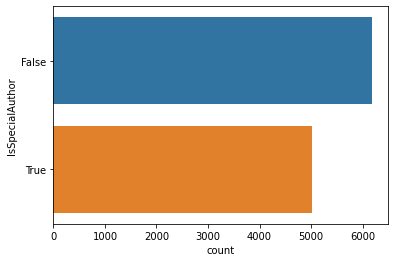

In [818]:
from Untitled import process_df
from livelossplot import PlotLossesKeras
import tensorflow as tf
import keras
df_train_processed = process_df(df, target_file="df_train_processed.csv")
df_test_processed = process_df(df_test, target_file='df_test_processed.csv', is_test=True)

In [836]:
len(df_train_processed.columns), len(df_test_processed.columns)


479 479 480


In [837]:

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def metric(ypred, yval):
    return 1 - tf.math.reduce_mean(tf.sqrt(tf.square(log10(ypred + 1) - log10(yval + 1))))

def metric_np(y_pred, y_true):
    return 1 - np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean())

def create_model():
    model = Sequential()
    model.add(Dense(100, input_dim=len(df_processed.columns)-1, activation="relu"))
#     model.add(Dense(40, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))
#     model.add(Dense(20, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dense(1))
    optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        loss='mean_squared_error',
        optimizer=adam,
        metrics=[tf.keras.metrics.MeanSquaredError(), metric],
    )
    return model

model = KerasRegressor(
    build_fn=create_model,
    epochs=1500,
    batch_size=100,
    verbose=1,
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="mean_squared_error",
    min_delta=1e-4,
    patience=10,
    verbose=1,
    mode="auto",
)
# model.fit(X, Y, callbacks=[PlotLossesKeras(), early_stopping], validation_data=(xval, yval), batch_size=20)
# model.fit(X, Y, callbacks=[PlotLossesKeras(), early_stopping], batch_size=20)

In [ ]:

model = KerasRegressor(build_fn=create_model, epochs=1000, batch_size=10, verbose=0, callbacks=[PlotLossesKeras(), early_stopping])
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_validate(model, xtrain, ytrain, cv=kfold, scoring={'main': 'neg_mean_squared_error', 'custom': make_scorer(metric_np, greater_is_better=True)}
                            , n_jobs=-1, verbose=0)
results

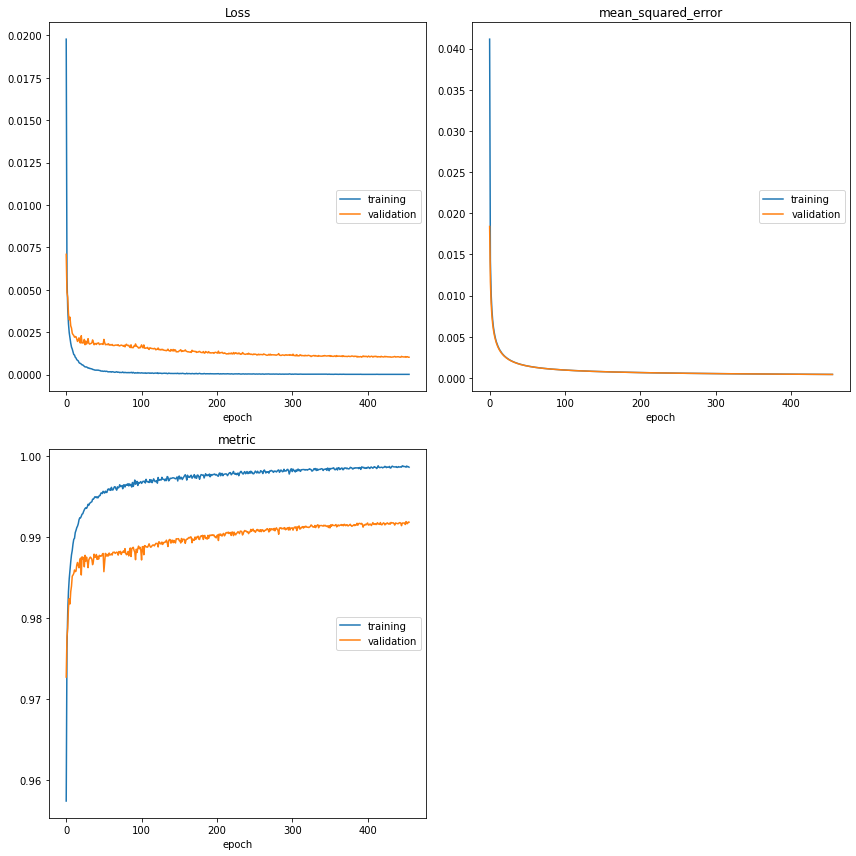

Loss
	training         	 (min:    0.000, max:    0.020, cur:    0.000)
	validation       	 (min:    0.001, max:    0.007, cur:    0.001)
mean_squared_error
	training         	 (min:    0.000, max:    0.041, cur:    0.000)
	validation       	 (min:    0.000, max:    0.018, cur:    0.000)
metric
	training         	 (min:    0.957, max:    0.999, cur:    0.999)
	validation       	 (min:    0.973, max:    0.992, cur:    0.992)
Epoch 00456: early stopping


In [840]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="mean_squared_error",
    min_delta=1e-5,
    patience=20,
    verbose=1,
    mode="auto",
)
model = KerasRegressor(build_fn=create_model, epochs=1000, batch_size=10, verbose=1, callbacks=[PlotLossesKeras(), early_stopping])
model.fit(xtrain, ytrain, callbacks=[PlotLossesKeras(), early_stopping], validation_data=(xtest, ytest))

In [845]:
len(df_test_processed.columns), len(xtrain.columns)

(466, 479)

In [958]:
import os
# prepare to generate word embbeding vectors
glove_input_file = "/Users/kdang/Documents/glove.6B/glove.6B.100d.txt"
word2vec_output_file = "glove.6B.100d.txt.word2vec"

if not os.path.exists(word2vec_output_file):
    glove2word2vec(glove_input_file, word2vec_output_file)

word_model = KeyedVectors.load_word2vec_format(word2vec_output_file)

def process_df(df, target_file=None, is_test=False):
    df = df.copy()
    df["RatingValue"] = df["Reviews"].apply(lambda x: float(x.split()[0]) / 5)
    df["NumReview"] = df["Ratings"].apply(lambda x: int(x.split()[0].replace(",", "")))
    months = [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ]
    monthsMaxDays = {
        "Jan": 31,
        "Feb": 28,
        "Mar": 31,
        "Apr": 30,
        "May": 31,
        "Jun": 30,
        "Jul": 31,
        "Aug": 31,
        "Sep": 30,
        "Oct": 31,
        "Nov": 30,
        "Dec": 31,
    }
    months_to_num = {}
    for i, m in enumerate(months):
        months_to_num[m] = i + 1
    months_to_num

    # In[583]:

    df.Edition = df.Edition.apply(lambda x: x.replace("–", "-").replace("-", "-"))
    df.loc[df.Edition.str.match(".*\(\w+\).*"), "Edition"] = df.loc[
        df.Edition.str.match(".*\(\w+\).*"), "Edition"
    ].apply(lambda x: re.sub("\(\w+\),", "", x))
    df.loc[
        df.Edition.str.match(r".*[^\d]+$"), "EditionDate"
    ] = np.nan  # pattern 1, year and month

    df.loc[df.Edition.str.match(r".*\d+$"), "EditionDate"] = df.Edition.apply(
        lambda x: x.split(",")[-1].split("-")[-1].strip()
    )

    df["Year"] = df.EditionDate.apply(
        lambda x: int(x[-4:].strip()) if pd.notnull(x) else np.nan
    )
    df["Month"] = df.EditionDate.apply(
        lambda x: x[-8:-4] if (pd.notnull(x) and len(x) > 8) else np.nan
    )
    df["Day"] = df.EditionDate.apply(
        lambda x: int(x[-11:-9].strip()) if (pd.notnull(x) and len(x) >= 10) else np.nan
    )
    sns.countplot(data=df, y="BookCategory")
    df["PrintEdition"] = df.Edition.apply(lambda x: x.split(",")[0])
    df["IsImported"] = df.Edition.str.contains("Import")
    df["IsBook"] = df.Genre.str.contains("(Books)")
    df["IsMultipleAuthor"] = df.Author.str.match(".*[,&-].*")
    df["IsSpecialAuthor"] = df.Author.apply(
        lambda x: any(
            i
            for i in x.lower().split()
            if i
            in [
                "phd.",
                "phd",
                "dr",
                "dr.",
                "prof",
                "prof.",
                "sir",
                "sir.",
                "m.d.",
                "m.d.",
                "mr",
                "mr.",
                "mrs",
                "mrs.",
                "m.a",
                "m.a.",
            ]
        )
    )

    def processTextColumn(df, col):
        df[f"{col}Token"] = df[col].str.lower()
        df[f"{col}Token"] = (
            df[f"{col}Token"]
            .str.replace("[^\w\s]", "")
            .apply(lambda x: [Word(i).lemmatize() for i in x.split()])
        )
        stop = stopwords.words("english")
        df[f"{col}Token"] = df[f"{col}Token"].apply(
            lambda x: [i for i in x if i not in stop]
        )
        df[f"{col}Vector"] = df[f"{col}Token"].apply(
            lambda x: np.mean(
                [(word_model[i] if i in word_model else np.zeros(100)) for i in x], axis=0
            )
            if x
            else np.zeros(100)
        )
    processTextColumn(df, "Synopsis")
    processTextColumn(df, "BookCategory")
    processTextColumn(df, "Title")
    processTextColumn(df, "Genre")
    df = df.drop(
        columns=["BookCategoryToken", "BookCategoryToken", "TitleToken", "GenreToken"]
    )

    min_year = df.Year.min()
    max_year = df.Year.max()
    df.loc[pd.isnull(df.Year), "Year"] = df.loc[pd.isnull(df.Year), "Year"].apply(
        lambda x: random.randrange(min_year, max_year + 1)
    )
    df.loc[pd.isnull(df.Month), "Month"] = df.loc[pd.isnull(df.Month), "Month"].apply(
        lambda x: random.choice(months)
    )
    df.loc[pd.isnull(df.Day), "Day"] = df.loc[
        df.loc[pd.isnull(df.Day)].index, "Month"
    ].apply(lambda x: random.randint(1, monthsMaxDays[x]))
    df['Day'] = df['Day'].astype(int)
#     if not is_test:
#         bins = [0, 1000, 5000, 100000]
#         df["PriceBinned"] = np.searchsorted(bins, df["Price"].values)

    df["IsImported"] = df["IsImported"].astype(int)
    df["Year"] = df["Year"].astype(int)
    df["IsBook"] = df["IsBook"].astype(int)
    df["IsMultipleAuthor"] = df["IsMultipleAuthor"].astype(int)
    df["IsSpecialAuthor"] = df["IsSpecialAuthor"].astype(int)
    df_processed = df.copy()
    df_processed = df_processed.drop(
        columns="Title Author Edition Reviews Ratings Synopsis Genre BookCategory EditionDate SynopsisToken".split()
    )
    df_processed["Year"] = MinMaxScaler().fit_transform([[i] for i in df.Year])
    df_processed["NumReview"] = MinMaxScaler().fit_transform(
        [[i] for i in df.NumReview]
    )
    def categorical_to_column(df, col, unique_values):
        print('-- unique values', unique_values)
        for i in unique_values:
            col_name = f"{col}_{i}"
            df[col_name] = df[col]==i
            df[col_name] = df[col_name].astype(int)
            
    categorical_to_column(df_processed, "Month", months)
    categorical_to_column(df_processed, "Day", list(range(1, 32)))
    categorical_to_column(
        df_processed,
        "PrintEdition",
        [
            "Paperback",
            "Hardcover",
            "Mass Market Paperback",
            "Sheet music",
            "Flexibound",
            "Plastic Comb",
            "Loose Leaf",
            "Tankobon Softcover",
            "Perfect Paperback",
            "Board book",
            "Cards",
            "Spiral-bound",
            "Product Bundle",
            "Library Binding",
            "Leather Bound",
        ],
    )
    df_processed = df_processed.drop(columns=["Month", "Day", "PrintEdition"])
#     df_processed = df_processed.drop(columns=["Month", "PrintEdition"])
    for col in ["GenreVector", "TitleVector", "BookCategoryVector", "SynopsisVector"]:
        for i in range(100):
            df_processed[f"{col}{i}"] = df_processed[col].apply(lambda x: x[i])
    df_processed = df_processed.drop(
        columns=["GenreVector", "TitleVector", "BookCategoryVector", "SynopsisVector"]
    )
    return df_processed

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: The default value of regex will change from True to False in a future version.


-- unique values ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
-- unique values [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
-- unique values ['Paperback', 'Hardcover', 'Mass Market Paperback', 'Sheet music', 'Flexibound', 'Plastic Comb', 'Loose Leaf', 'Tankobon Softcover', 'Perfect Paperback', 'Board book', 'Cards', 'Spiral-bound', 'Product Bundle', 'Library Binding', 'Leather Bound']


/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: The default value of regex will change from True to False in a future version.


-- unique values ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
-- unique values [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
-- unique values ['Paperback', 'Hardcover', 'Mass Market Paperback', 'Sheet music', 'Flexibound', 'Plastic Comb', 'Loose Leaf', 'Tankobon Softcover', 'Perfect Paperback', 'Board book', 'Cards', 'Spiral-bound', 'Product Bundle', 'Library Binding', 'Leather Bound']


(465, 466)

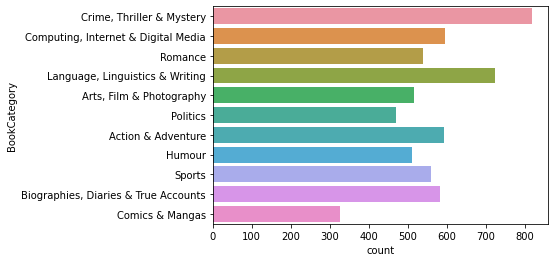

In [941]:
df_train = pd.read_excel('Participants_Data/Data_Train.xlsx')
df_train_processed = process_df(df_train)
df_test = pd.read_excel('Participants_Data/Data_Test.xlsx')
df_test_processed = process_df(df_test, is_test=True)
len(df_test_processed.columns), len(df_train_processed.columns)

In [942]:
set(df_train_processed.columns).difference(set(df_test_processed.columns))

{'Price'}

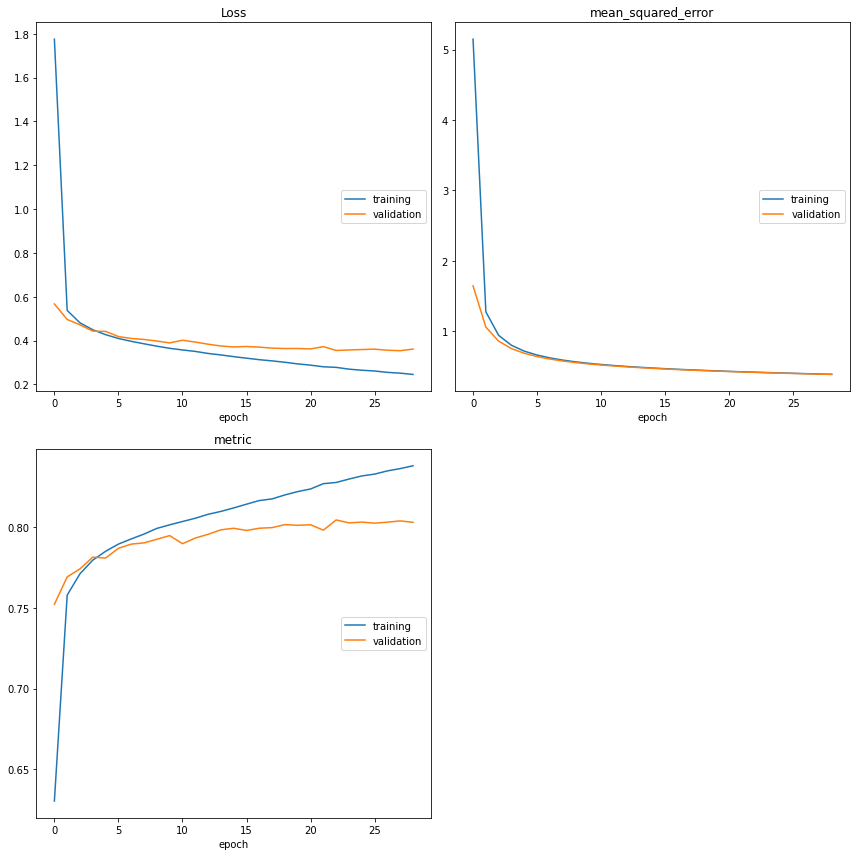

Loss
	training         	 (min:    0.245, max:    1.775, cur:    0.245)
	validation       	 (min:    0.354, max:    0.567, cur:    0.361)
mean_squared_error
	training         	 (min:    0.391, max:    5.148, cur:    0.391)
	validation       	 (min:    0.389, max:    1.647, cur:    0.389)
metric
	training         	 (min:    0.630, max:    0.838, cur:    0.838)
	validation       	 (min:    0.752, max:    0.804, cur:    0.803)
Epoch 00029: early stopping


In [944]:
import math
def metric(ypred, yval):
    ypred = math.e **ypred
    yval = math.e**yval
    return 1 - tf.math.reduce_mean(tf.sqrt(tf.square(log10(ypred + 1) - log10(yval + 1))))

def create_model():
    model = Sequential()
    model.add(Dense(40, input_dim=len(df_train_processed.columns)-1, activation="relu"))
    model.add(Dense(20, activation="relu"))
    model.add(Dense(10, activation="relu"))
#     model.add(Dense(40, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))
#     model.add(Dense(20, activation="relu", kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dense(1))
    optim = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        loss='mean_squared_error',
        optimizer=adam,
        metrics=[tf.keras.metrics.MeanSquaredError(), metric],
    )
    return model
xtrain, xtest, ytrain, ytest = train_test_split(df_train_processed.drop(columns=['Price']), df_train_processed.Price, test_size=0.2, random_state=42)
ytrain = np.log(ytrain)
ytest = np.log(ytest)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="mean_squared_error",
    min_delta=1e-1,
    patience=10,
    verbose=1,
    mode="auto"
)

# model = KerasRegressor(build_fn=create_model, epochs=1000, batch_size=10, verbose=0, callbacks=[PlotLossesKeras(), early_stopping])
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# results = cross_validate(model, xtrain, ytrain, cv=kfold, scoring={'main': 'neg_mean_squared_error', 'custom': make_scorer(metric_np, greater_is_better=True)}
#                             , n_jobs=-1, verbose=1)
# results
# model = KerasRegressor(build_fn=create_model, epochs=1000, batch_size=10, verbose=1)
# model.fit(xtrain, ytrain, callbacks=[PlotLossesKeras(), early_stopping], validation_data=(xtest, ytest))

In [939]:
set(xtrain.columns).difference(set(df_test_processed.columns))

{'PriceBinned'}

In [945]:
price = model.predict(df_test_processed)
price = math.e**price
df_test['Price'] = price
df_test.to_excel('test_submission.xlsx')

156/156 [==============================] - 0s 424us/step


In [946]:
import lightgbm

In [947]:
from lightgbm import LGBMRegressor

In [951]:
lightgbm_model = LGBMRegressor()
lightgbm_model.fit(xtrain, ytrain)

LGBMRegressor()

/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
/Users/kdang/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:106: FutureWarning: The default value of regex will change from True to False in a future version.


-- unique values ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
-- unique values [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
-- unique values ['Paperback', 'Hardcover', 'Mass Market Paperback', 'Sheet music', 'Flexibound', 'Plastic Comb', 'Loose Leaf', 'Tankobon Softcover', 'Perfect Paperback', 'Board book', 'Cards', 'Spiral-bound', 'Product Bundle', 'Library Binding', 'Leather Bound']


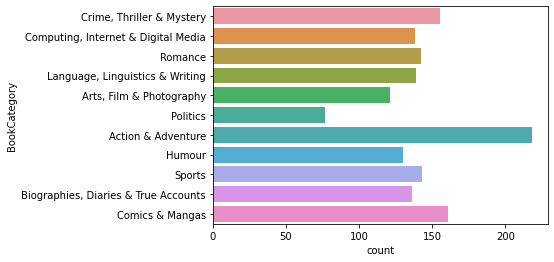

In [959]:
df_test = pd.read_excel('Participants_Data/Data_Test.xlsx')
df_test_processed = process_df(df_test, is_test=True)
price = lightgbm_model.predict(df_test_processed)
price = math.e**price
df_test['Price'] = price
df_test.to_excel('test_submission.xlsx')